In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm
from wordcloud import WordCloud

In [10]:
df = pd.read_csv('./customs_mail.csvv', low_memory=True)

In [11]:
df_etc = df[df['우편물검사결과코드.2'] =='99-기타']

In [12]:
df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# df_etc['cleansing'] = df_etc['cleansing'].str.replace("기타농산물","농산물").str.replace("이삿짐","이사화물").str.replace("담배반송"," 담배").str.replace("담배 반송"," 담배").str.replace("농산물반송"," 농산물").str.replace("농산물 반송"," 농산물").str.replace("이사화물 반송","이사화물").str.replace("기타담배반송","담배").str.replace("과일반송","과일").str.replace("기타 담배반송","담배").str.replace("기타 이사화물반송","이사화물")
# df_etc['cleansing'] = df_etc['cleansing'].str.replace("기타비전자반송","비전자상거래").str.replace("기타비전자상거래물품","비전자상거래").str.replace("농산물  담배","담배").str.replace("반송농산물","농산물").str.replace("비전자 반송","비전자상거래")\
# .str.replace("비전자상거래 반송","비전자상거래").str.replace("비전자상거래물품","비전자상거래").str.replace("비전자상거래반송","비전자상거래").str.replace("이사물품 반송","이사물품")
# df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타 담배","담배").str.replace("기타담배","담배").str.replace("기타반송","기타").str.replace("농산물 담배","담배").str.replace("농산물담배","담배")\
# .str.replace("반송담배","담배").str.replace("비전자반송","비전자상거래").str.replace("인근분산반입   농산물","농산물").str.replace("이사물품반송","이사물품")
df_test = df_etc.copy()

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5752\3669874638.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5752\3669874638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5752\3669874638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [13]:
df_etc.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,cleansing
705,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)비전자상거래,농산물말린고추비전자상거래
706,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)-비전자상거래물품,농산물말린고추비전자상거래
762,2019,20191113,2019,99,기타,99-기타,농산물 반송,농산물


In [14]:
okt = Okt()
tokenized_data = []
for sentence in tqdm.tqdm(df_etc['cleansing']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    tokenized_data.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 14563/14563 [00:04<00:00, 3260.57it/s]


In [21]:
df_test['nouns'] = tokenized_data

In [22]:
df_test.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,cleansing,nouns
705,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)비전자상거래,농산물말린고추비전자상거래,"[농산물, 말리다, 고추, 비, 전자상거래]"
706,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)-비전자상거래물품,농산물말린고추비전자상거래,"[농산물, 말리다, 고추, 비, 전자상거래]"
762,2019,20191113,2019,99,기타,99-기타,농산물 반송,농산물,[농산물]


In [42]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 0)

In [56]:
# df_test['vec'] = df_test['nouns'].apply(lambda x: np.mean([model.wv[w] for w in x if w in model.wv], axis=0))
# vectors = df_test['nouns'].apply(lambda x: np.mean([model.wv[w] for w in x if w in model.wv], axis=0))
vectors = df_test['nouns'].apply(lambda x: np.array(np.mean([model.wv[w] for w in x if w in model.wv], axis=0)))


In [58]:
padded_vectors = []
for vector in vectors:
    if isinstance(vector, np.ndarray):
        if len(vector) != 100:
            padding = np.zeros(100 - len(vector))
            padded_vector = np.concatenate((vector, padding))
            padded_vectors.append(padded_vector)
        else:
            padded_vectors.append(vector)
    else:
        padded_vectors.append(vector)

df_test['padded_vectors'] = padded_vectors

In [62]:
df_test.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,cleansing,nouns,vec,padded_vectors
705,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)비전자상거래,농산물말린고추비전자상거래,"[농산물, 말리다, 고추, 비, 전자상거래]","[0.12794033, 0.1798052, 0.12508775, -0.0895779...","[0.12794033, 0.1798052, 0.12508775, -0.0895779..."
706,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)-비전자상거래물품,농산물말린고추비전자상거래,"[농산물, 말리다, 고추, 비, 전자상거래]","[0.12794033, 0.1798052, 0.12508775, -0.0895779...","[0.12794033, 0.1798052, 0.12508775, -0.0895779..."
762,2019,20191113,2019,99,기타,99-기타,농산물 반송,농산물,[농산물],"[0.10810821, 0.14386226, 0.1103304, -0.0632499...","[0.10810821, 0.14386226, 0.1103304, -0.0632499..."


In [64]:
max_len = max([len(v) for v in df_test['padded_vectors'] if isinstance(v, np.ndarray)])

In [65]:
padded_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in df_test['padded_vectors'] if isinstance(v, np.ndarray)]

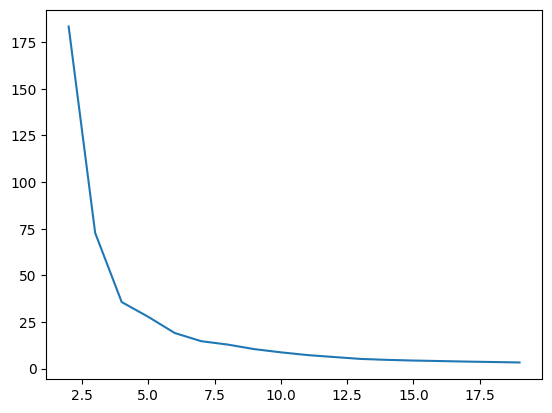

In [66]:
itr = []
for i in range(2,20):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(padded_vectors)
    itr.append(km.inertia_)
    
plt.plot(range(2,20), itr)
plt.show()

In [68]:
# KMeans 알고리즘을 적용합니다.
kmeans = KMeans(n_clusters=4, random_state=42,init='k-means++',max_iter=100, n_init=1)
kmeans.fit(df_test['padded_vectors'])

# 군집 결과를 확인합니다.
labels = kmeans.labels_
df_test['cluster'] = labels

ValueError: setting an array element with a sequence.

In [143]:
df = pd.read_csv('./customs_mail.csvv', low_memory=True)
df_etc = df[df['우편물검사결과코드.2'] =='99-기타']
df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# df_etc['cleansing'] = df_etc['cleansing'].str.replace("기타농산물","농산물").str.replace("이삿짐","이사화물").str.replace("담배반송"," 담배").str.replace("담배 반송"," 담배").str.replace("농산물반송"," 농산물").str.replace("농산물 반송"," 농산물").str.replace("이사화물 반송","이사화물").str.replace("기타담배반송","담배").str.replace("과일반송","과일").str.replace("기타 담배반송","담배").str.replace("기타 이사화물반송","이사화물")
# df_etc['cleansing'] = df_etc['cleansing'].str.replace("기타비전자반송","비전자상거래").str.replace("기타비전자상거래물품","비전자상거래").str.replace("농산물  담배","담배").str.replace("반송농산물","농산물").str.replace("비전자 반송","비전자상거래")\
# .str.replace("비전자상거래 반송","비전자상거래").str.replace("비전자상거래물품","비전자상거래").str.replace("비전자상거래반송","비전자상거래").str.replace("이사물품 반송","이사물품")
# df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타 담배","담배").str.replace("기타담배","담배").str.replace("기타반송","기타").str.replace("농산물 담배","담배").str.replace("농산물담배","담배")\
# .str.replace("반송담배","담배").str.replace("비전자반송","비전자상거래").str.replace("인근분산반입   농산물","농산물").str.replace("이사물품반송","이사물품")
df_test = df_etc.copy()

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5752\948471287.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5752\948471287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['cleansing'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [144]:
okt = Okt()
tokenized_data = []
for sentence in tqdm.tqdm(df_etc['cleansing']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    tokenized_data.append(tokenized_sentence)
df_test['nouns'] = tokenized_data

vectors = df_test['nouns'].apply(lambda x: np.array(np.mean([model.wv[w] for w in x if w in model.wv], axis=0)))

df_test['padded_vectors'] = vectors

100%|██████████████████████████████████████████████████████████████████████████| 14563/14563 [00:06<00:00, 2378.62it/s]
C:\python\ml_py308\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [145]:
# NaN 값을 제거합니다.
df_test = df_test.dropna(subset=['padded_vectors'])

# 비원진 값을 0으로 대입하여 최대크기(100차원) 벡터길이로 모든 자료를 맞춥니다.
max_len = max([len(v) for v in df_test['padded_vectors'] if isinstance(v, np.ndarray)])
padded_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in df_test['padded_vectors'] if isinstance(v, np.ndarray)]
df_test['padded_vectors'] = padded_vectors

In [153]:
padded_vectors.shape

AttributeError: 'list' object has no attribute 'shape'

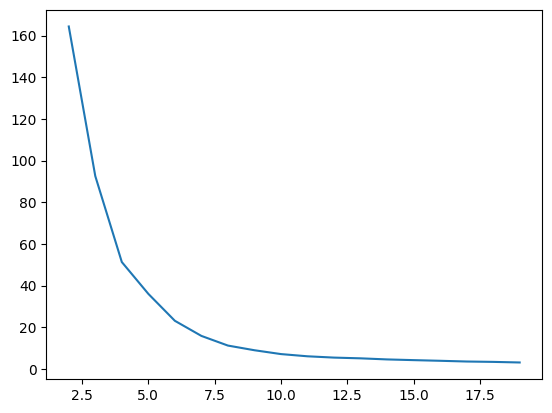

In [152]:
itr = []
for i in range(2,20):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(padded_vectors)
    itr.append(km.inertia_)
    
plt.plot(range(2,20), itr)
plt.show()

In [157]:
# 2차원 배열 형태로 변환합니다.
X = np.array(padded_vectors)
# KMeans 알고리즘을 적용합니다.
kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

# 군집 결과를 확인합니다.
labels = kmeans.labels_
df_test['cluster'] = labels

In [155]:
df_test

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,cleansing,nouns,padded_vectors,cluster
705,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)비전자상거래,농산물말린고추비전자상거래,"[농산물, 말리다, 고추, 비, 전자상거래]","[0.12794033, 0.1798052, 0.12508775, -0.0895779...",1
706,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)-비전자상거래물품,농산물말린고추비전자상거래물품,"[농산물, 말리다, 고추, 비, 전자상거래, 물품]","[0.14048469, 0.18943284, 0.13805228, -0.093840...",2
762,2019,20191113,2019,99,기타,99-기타,농산물 반송,농산물 반송,"[농산물, 반송]","[0.0902149, 0.126681, 0.08721616, -0.061026465...",0
935,2019,20191125,2019,99,기타,99-기타,이사화물 반송,이사화물 반송,"[이, 사, 화물, 반송]","[0.17045091, 0.20447268, 0.16480388, -0.117037...",2
1015,2019,20191219,2019,99,기타,99-기타,과일/반송,과일반송,"[과일, 반송]","[0.058007568, 0.08521374, 0.051173463, -0.0416...",0
...,...,...,...,...,...,...,...,...,...,...,...
1211984,2023,20230316,2023,99,기타,99-기타,농산물,농산물,[농산물],"[0.10810821, 0.14386226, 0.1103304, -0.0632499...",1
1211985,2023,20230316,2023,99,기타,99-기타,농산물,농산물,[농산물],"[0.10810821, 0.14386226, 0.1103304, -0.0632499...",1
1213154,2023,20230605,2023,99,기타,99-기타,농산물 반송,농산물 반송,"[농산물, 반송]","[0.0902149, 0.126681, 0.08721616, -0.061026465...",0
1214560,2023,20230705,2023,99,기타,99-기타,농산물반송,농산물반송,"[농산물, 반송]","[0.0902149, 0.126681, 0.08721616, -0.061026465...",0


In [79]:
def wordcloud(grp,model):
    g1 = df_test[df_test[model] == grp].groupby('검사결과내용')['검사결과내용'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row  in enumerate(g1.iterrows()):
        g1_ditc[row[1]['검사결과내용']]=row[1]['cnt']

    wordcloud = WordCloud(
    font_path = 'malgun.ttf', # 한글 글씨체 설정
    background_color='white', # 배경색은 흰색으로 
    colormap='Reds', # 글씨색은 빨간색으로
    # mask=cand_mask, # 워드클라우드 모양 설정
    ).generate_from_frequencies(g1_ditc)
    
    #사이즈 설정 및 출력
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.show()

    print('---' * 30)

C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


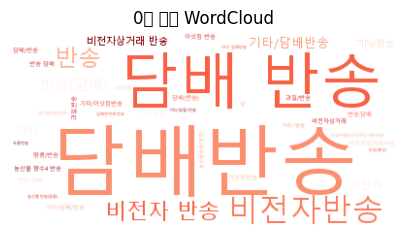

------------------------------------------------------------------------------------------


C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


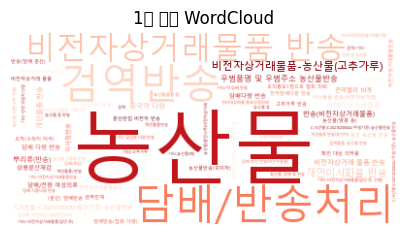

------------------------------------------------------------------------------------------


C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


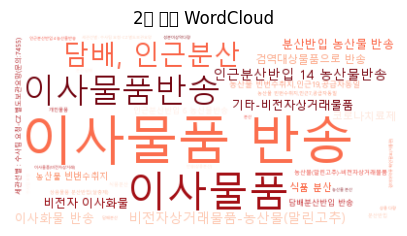

------------------------------------------------------------------------------------------


C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\python\ml_py308\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


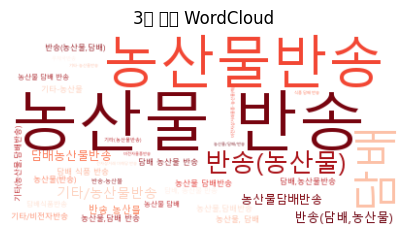

------------------------------------------------------------------------------------------


In [158]:
# 그룹별 워드클라우드 시각화
for i in range(df_test['cluster'].max()+1):
    wordcloud(i,'cluster')